In [1]:
from unemployment import *
from unemployment import evaluate_model, plot_predictions, display_metrics_table

In [2]:
from pygam import LinearGAM, s

In [3]:
# file_path = "fredupdated.csv"
# df = pd.read_csv(file_path, parse_dates=['observation_date'])
# df.set_index('observation_date', inplace=True)

# # Filter data starting from 1959
# start_date = '1959-01-01'
# df = df.loc[start_date:].reset_index()

# # # Filter out data after Q1 2020 (March 31, 2020)
# # q1_2020_end = '2020-03-31'
# # df = df[df['observation_date'] <= q1_2020_end].reset_index(drop=True)

# # Calculate inflation rate (year-over-year percent change in CPI)
# df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
# df.drop(columns=['CPIAUCSL'], inplace=True)

# # Handle missing values
# df.fillna(method='ffill', inplace=True)
# df.fillna(method='bfill', inplace=True)

# # Feature Engineering - Create first difference of unemployment rate
# df['UNRATE_Diff1'] = df['UNRATE'].diff()

# # Create lag features for key variables
# lag_features = ['UNRATE', 'GDP', 'FEDFUNDS', 'GS10', 'Inflation_Rate']
# lags = [1, 4]  # 1-quarter and 4-quarter lags

# for col in lag_features:
#     for lag in lags:
#         df[f'{col}_Lag{lag}Q'] = df[col].shift(lag)

# # Drop rows with NaN values after creating lag features
# df.dropna(inplace=True)

# # Create a copy of the original dataframe for the original visualizations
# df_original = df.copy()

# # Feature Selection (based on multicollinearity)
# # First round of dropping high-VIF features
# drop_cols_1 = [
#     'GDP',     # Keep GDPC1 instead
#     'PCE',     # Redundant with GDP
#     'M2SL',    # Redundant with GDP
#     'PPIACO',  # Redundant with GDP
#     'GS10',    # Keep FEDFUNDS instead
# ]
# df = df.drop(columns=drop_cols_1, errors='ignore')

# # Second round of dropping high-VIF features
# drop_cols_2 = [
#     'GDP_Lag1Q', 
#     'GDP_Lag4Q',  # GDP lags too collinear, keeping GDPC1 instead
#     'Inflation_Rate_Lag1Q',    # Drop due to high correlation with Inflation_Rate
#     'GS10_Lag1Q',              # Drop short-term, keep GS10_Lag4Q (long-term rates)
#     'FEDFUNDS_Lag1Q'           # Drop, keeping FEDFUNDS
# ]
# df = df.drop(columns=drop_cols_2, errors='ignore')

# # Third round of dropping high-VIF features
# drop_cols_3 = [
#     'CIVPART',              # Too correlated with UNRATE
#     # 'UNRATE_Lag4Q',         # Redundant with UNRATE_Lag1Q
#     'GS10_Lag4Q',           # High VIF, FEDFUNDS already captures monetary policy
#     'Inflation_Rate_Lag4Q'  # High VIF, keeping Inflation_Rate instead
# ]
# df = df.drop(columns=drop_cols_3, errors='ignore')

# # Define the final set of features for modeling (similar to the notebook)
# final_predictors = [
#     'FEDFUNDS', 
#     'GDPC1', 
#     'Inflation_Rate', 
#     'UNRATE_Diff1', 
#     # 'UNRATE_Lag1Q', 
#     'UNRATE_Lag4Q',
#     'FEDFUNDS_Lag4Q'
# ]

# # Keep a copy of the transformed dataframe for modeling
# df_model = df.copy()

In [4]:
file_path = "fredupdated.csv"
df = pd.read_csv(file_path, parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)

# Filter data starting from 1959
start_date = '1959-01-01'
df = df.loc[start_date:].reset_index()

# Calculate inflation rate (year-over-year percent change in CPI)
df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
df.drop(columns=['CPIAUCSL'], inplace=True)

# Handle missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Feature Engineering - Create first difference of unemployment rate
df['UNRATE_Diff1'] = df['UNRATE'].diff()

# NEW: Add seasonal differencing (diff12) for key variables
seasonal_diff_vars = ['UNRATE', 'GDP', 'FEDFUNDS', 'Inflation_Rate']
for col in seasonal_diff_vars:
    if col in df.columns:
        df[f'{col}_Diff12'] = df[col].diff(12)

# Create lag features for key variables
lag_features = ['UNRATE', 'GDP', 'FEDFUNDS', 'GS10', 'Inflation_Rate']
lags = [1, 4]  # 1-quarter and 4-quarter lags

for col in lag_features:
    for lag in lags:
        df[f'{col}_Lag{lag}Q'] = df[col].shift(lag)

# NEW: Create lag features for the seasonally differenced variables
seasonal_lag_features = ['UNRATE_Diff12', 'GDP_Diff12', 'FEDFUNDS_Diff12', 'Inflation_Rate_Diff12']
for col in seasonal_lag_features:
    if col in df.columns:
        for lag in [1, 4]:  # 1-quarter and 4-quarter lags
            df[f'{col}_Lag{lag}Q'] = df[col].shift(lag)

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

# Create a copy of the original dataframe for the original visualizations
df_original = df.copy()

# Feature Selection (based on multicollinearity)
# First round of dropping high-VIF features
drop_cols_1 = [
    'GDP',     # Keep GDPC1 instead
    'PCE',     # Redundant with GDP
    'M2SL',    # Redundant with GDP
    'PPIACO',  # Redundant with GDP
    'GS10',    # Keep FEDFUNDS instead
]
df = df.drop(columns=drop_cols_1, errors='ignore')

# Second round of dropping high-VIF features
drop_cols_2 = [
    'GDP_Lag1Q', 
    'GDP_Lag4Q',  # GDP lags too collinear, keeping GDPC1 instead
    'Inflation_Rate_Lag1Q',    # Drop due to high correlation with Inflation_Rate
    'GS10_Lag1Q',              # Drop short-term, keep GS10_Lag4Q (long-term rates)
    'FEDFUNDS_Lag1Q'           # Drop, keeping FEDFUNDS
]
df = df.drop(columns=drop_cols_2, errors='ignore')

# Third round of dropping high-VIF features
drop_cols_3 = [
    'CIVPART',              # Too correlated with UNRATE
    # 'UNRATE_Lag4Q',         # Redundant with UNRATE_Lag1Q
    'GS10_Lag4Q',           # High VIF, FEDFUNDS already captures monetary policy
    'Inflation_Rate_Lag4Q'  # High VIF, keeping Inflation_Rate instead
]
df = df.drop(columns=drop_cols_3, errors='ignore')

# Define the final set of features for modeling (including new seasonal diff features)
final_predictors = [
    'FEDFUNDS', 
    'GDPC1', 
    'Inflation_Rate', 
    'UNRATE_Diff1',
    # 'UNRATE_Lag1Q', 
    'UNRATE_Lag4Q',
    'FEDFUNDS_Lag4Q',
    # Adding new seasonal difference features
    'UNRATE_Diff12',
    'FEDFUNDS_Diff12',
    'Inflation_Rate_Diff12',
    # Adding key lag versions of seasonal differences
    'UNRATE_Diff12_Lag4Q',
    'Inflation_Rate_Diff12_Lag4Q'
]

# Keep a copy of the transformed dataframe for modeling
df_model = df.copy()

# Add quarterly dummies if desired 
df_model['quarter'] = pd.DatetimeIndex(df_model['observation_date']).quarter
df_model = pd.get_dummies(df_model, columns=['quarter'], prefix='Q')

# Add final quarterly dummies to predictors if desired
final_predictors.extend(['Q_1', 'Q_2', 'Q_3', 'Q_4'])

# Ensure all predictors exist in the dataframe
final_predictors = [col for col in final_predictors if col in df_model.columns]

# Print the final predictors used
print("Final predictors used:")
for predictor in final_predictors:
    print(f"- {predictor}")

Final predictors used:
- FEDFUNDS
- GDPC1
- Inflation_Rate
- UNRATE_Diff1
- UNRATE_Lag4Q
- FEDFUNDS_Lag4Q
- UNRATE_Diff12
- FEDFUNDS_Diff12
- Inflation_Rate_Diff12
- UNRATE_Diff12_Lag4Q
- Inflation_Rate_Diff12_Lag4Q
- Q_1
- Q_2
- Q_3
- Q_4


/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_98107/1012276889.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_98107/1012276889.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_98107/1012276889.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# Visualization
- We visualize:
    - Quarterly unemployment rate in the US from 1948 to 2025.
    - 10 year rolling mean of the unemployment rate.
    - Unemployment vs Inflation philips curve.

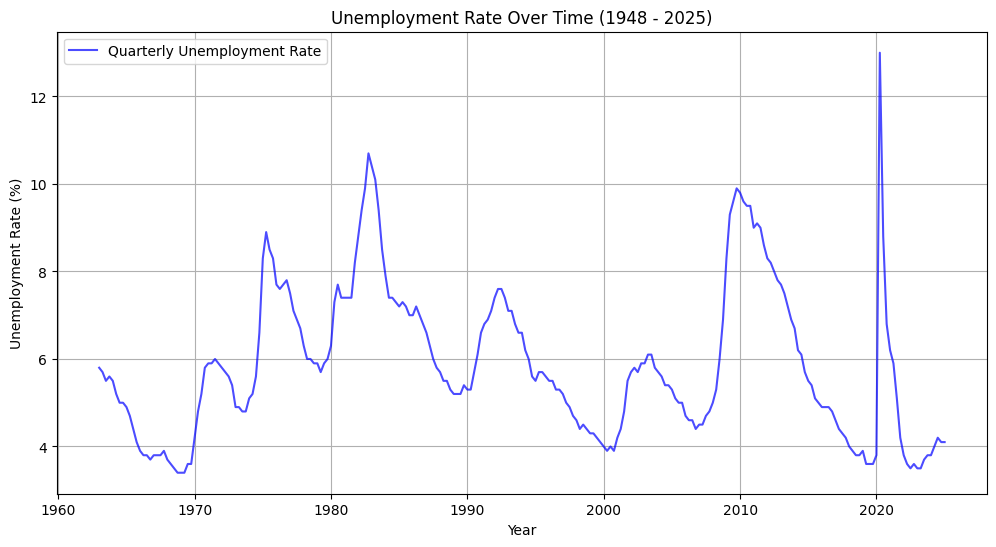

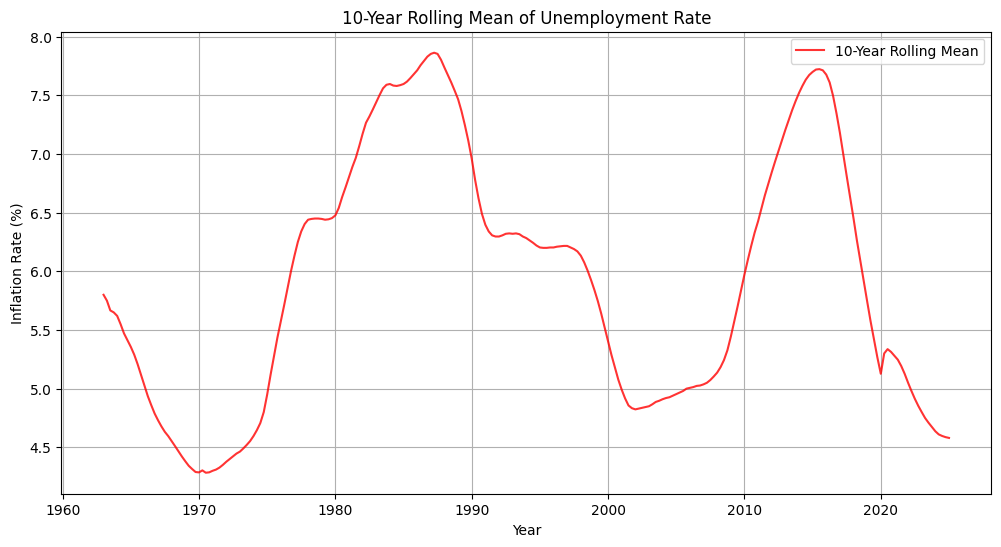

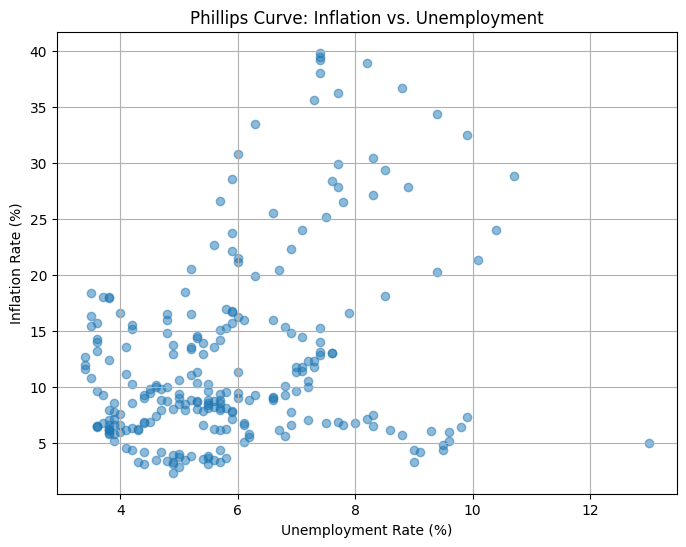

In [5]:
# Time Series Plot: Monthly Inflation Rate
plt.figure(figsize=(12, 6))
plt.plot(df_original['observation_date'], df_original['UNRATE'], label='Quarterly Unemployment Rate', color='blue', alpha=0.7)
plt.title("Unemployment Rate Over Time (1948 - 2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# 10-Year (120 months -> 30 quarters) Rolling Mean of Inflation Rate
df['Rolling_UNRATE'] = df['UNRATE'].rolling(window=30, min_periods=1).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['observation_date'], df['Rolling_UNRATE'], label='10-Year Rolling Mean', color='red', alpha=0.8)
plt.title("10-Year Rolling Mean of Unemployment Rate")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Inflation vs. Unemployment (Phillips Curve)
plt.figure(figsize=(8, 6))
plt.scatter(df_model['UNRATE'], df_model['Inflation_Rate'], alpha=0.5)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Inflation Rate (%)")
plt.title("Phillips Curve: Inflation vs. Unemployment")
plt.grid(True)
plt.show()

In [6]:
# Target = unemployment rate
# Predictor = inflation rate
X = df_model[final_predictors].values
y = df_model['UNRATE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [7]:
unemployment_data = df_model['UNRATE']
dates = df_model['observation_date']

In [8]:
# FOR ARIMA
train_data = pd.Series(y_train)
test_data = pd.Series(y_test)

In [9]:
train_size = len(train_data)
train_dates = dates[:train_size]
test_dates = dates[train_size:]

In [10]:
# 4: ARIMA with Standard Parameters
# Fit ARIMA model (p=1, d=1, q=1) - standard parameters for economic data
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  199
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.841
Date:                Mon, 10 Mar 2025   AIC                             27.682
Time:                        21:47:45   BIC                             37.547
Sample:                             0   HQIC                            31.675
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6258      0.054     11.556      0.000       0.520       0.732
ma.L1          0.0456      0.083      0.547      0.585      -0.118       0.209
sigma2         0.0651      0.005     13.420      0.000       0.056       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                61.10
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.57
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
train_predictions = model_fit.predict(start=0, end=len(train_data)-1)
test_predictions = model_fit.forecast(steps=len(test_data))

train_metrics = evaluate_model(train_data, train_predictions, "Training")
test_metrics = evaluate_model(test_data, test_predictions, "Test")

In [12]:
display_metrics_table(train_metrics, test_metrics, model_name="ARIMA(1,1,1)")


Model Evaluation: ARIMA(1,1,1)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.2339                9.8241
RMSE            0.4836                3.1343
MAE             0.2125                2.8602
R^2             0.9141                -2.1496
Accuracy        0.9205                0.3806
Accuracy (%)    92.05%              38.06%
------------------------------------------------------------


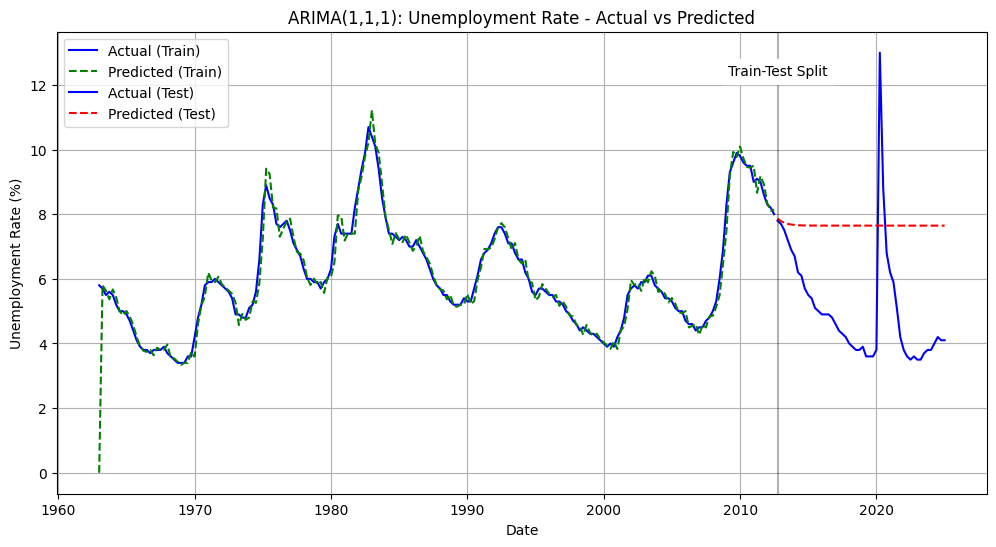

In [13]:
plot_predictions(
    train_data, train_predictions, 
    test_data, test_predictions,
    train_dates, test_dates, 
    model_name="ARIMA(1,1,1)"
)


Model Evaluation: Random Forest
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.0261                1.3460
RMSE            0.1615                1.1602
MAE             0.1049                0.8042
R^2             0.9904                0.5685
Accuracy        0.9734                0.7707
Accuracy (%)    97.34%              77.07%
------------------------------------------------------------


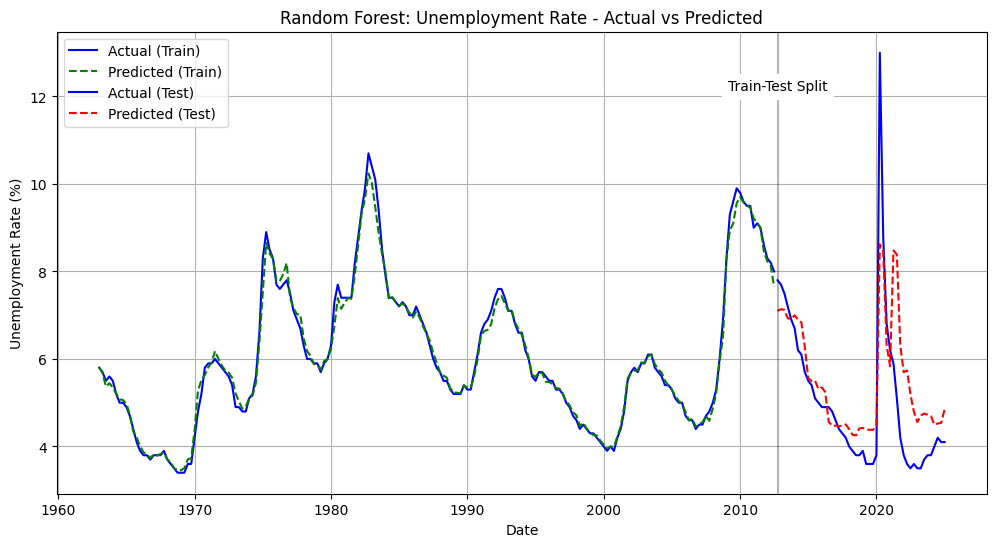

In [14]:
# 5: Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name="Random Forest")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="Random Forest"
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best k value: 3
Training KNN Regression model with k=3...

Model Evaluation: KNN (k=3)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.3475                2.1264
RMSE            0.5895                1.4582
MAE             0.3905                1.1907
R^2             0.8724                0.3183
Accuracy        0.9030                0.7118
Accuracy (%)    90.30%              71.18%
------------------------------------------------------------


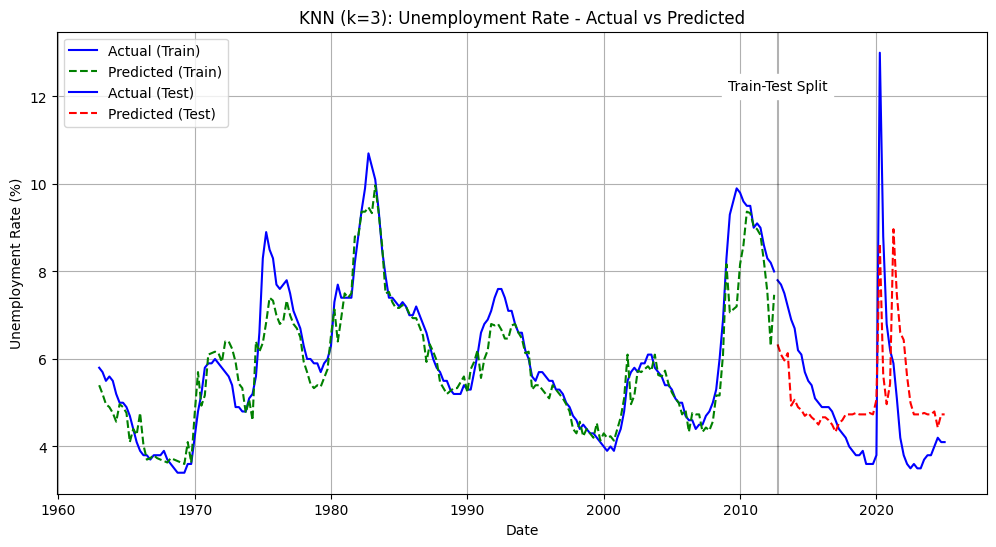

In [15]:
# 6: k-Nearest Neighbors Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# optimal k using cross-validation
param_grid = {'n_neighbors': range(1, 30, 2)}
grid_search = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

print(f"Training KNN Regression model with k={best_k}...")
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

train_predictions = knn_model.predict(X_train_scaled)
test_predictions = knn_model.predict(X_test_scaled)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name=f"KNN (k={best_k})")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name=f"KNN (k={best_k})"
)

In [16]:
# 7: GAM with Spline Terms 
# have to use scikit cause pygam has issues with numpy's new release

spline_features = []
for i, feature_name in enumerate(final_predictors):
    spline_features.append(
        (f'spline_{feature_name}', 
         make_pipeline(SplineTransformer(n_knots=5, degree=3)), 
         [i])
    )

# Create column transformer that applies splines to each feature
preprocessor = ColumnTransformer(spline_features, remainder='passthrough')

# Create a pipeline with the preprocessor and a ridge regression model
# Ridge adds some regularization to prevent overfitting
gam_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.1))  # Alpha controls regularization strength
])

# Fit the model to the training data
gam_model.fit(X_train_scaled, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('spline_FEDFUNDS',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [0]),
                                                 ('spline_GDPC1',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [1]),
                                                 ('spline_Inflation_Rate',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [2]),
                                                 ('splin...
                                                 ('spline_Q_1',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [11]),
                                                 ('spline_Q_2',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [12]),
                                                 ('spline_Q_3',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [13]),
                                                 ('spline_Q_4',
                                                  Pipeline(steps=[('splinetransformer',
                                                                   SplineTransformer())]),
                                                  [14])])),
                ('regressor', Ridge(alpha=0.1))])


Model Evaluation: GAM (scikit-learn)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.0444                1.6617
RMSE            0.2106                1.2891
MAE             0.1642                0.9873
R^2             0.9837                0.4673
Accuracy        0.9654                0.7452
Accuracy (%)    96.54%              74.52%
------------------------------------------------------------


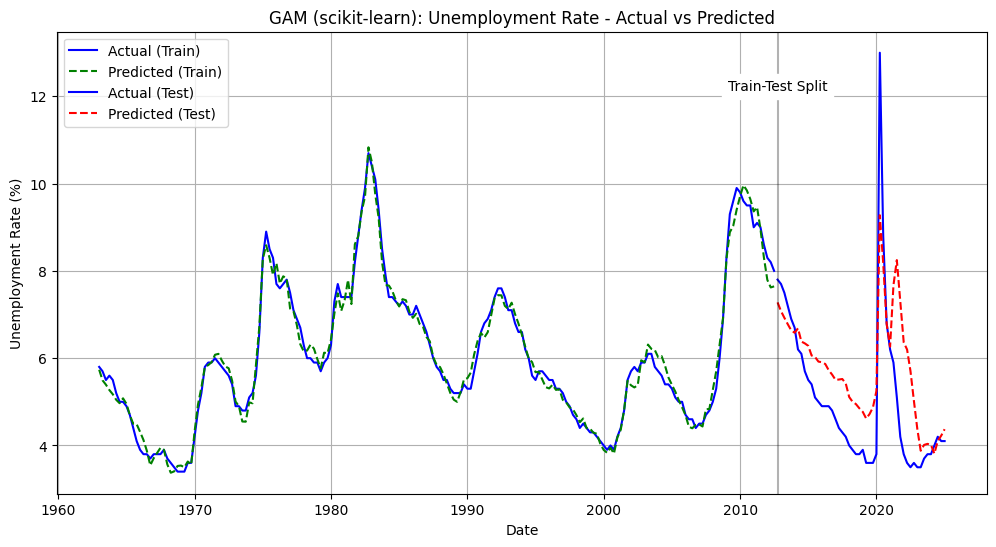

In [17]:
train_predictions = gam_model.predict(X_train_scaled)
test_predictions = gam_model.predict(X_test_scaled)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name="GAM (scikit-learn)")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="GAM (scikit-learn)"
)